In [9]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import folium
from folium.plugins import HeatMap
%matplotlib inline

In [10]:
# Detectar la base del proyecto y la ruta al CSV
BASE_DIR = Path('..').resolve()  # si corres desde notebooks/ este es el comportamiento esperado
csv_path = BASE_DIR / 'data_clean' / 'master' / 'master_dataset_final_wide.csv'
print('CSV:', csv_path)
df = pd.read_csv(csv_path, parse_dates=['timestamp'])
print('Dimensiones:', df.shape)
df.head()

CSV: /Users/mrescobar/dev/Proyecto2--Python/data_clean/master/master_dataset_final_wide.csv
Dimensiones: (145, 24)


,timestamp,station_id,station_name,lat,lon,source,date,hour,year,month,...,roughness_m,gradient,distance_to_river_m,terrain_class,flood_risk,landslide_risk,HUMEDAD,LLUVIA,TEMP,VIENTO
0,2025-11-26 14:00:00,93002,AEROPUERTO DE BOCAS (93-002),9.3403,-82.2450,IMHPA,2025-11-26,14:00:00,2025.0,11.0,...,6.0,0.027400,2250.243053,lomereo_suave,0.002866,0.050906,93.1,NaN,NaN,1.0
1,2025-11-26 14:00:00,93002,AEROPUERTO DE BOCAS (93-002),9.3403,-82.2450,IMHPA,2025-11-26,14:00:00,2025.0,11.0,...,10.0,0.046124,2250.243053,muy_montanoso,0.336525,0.146206,NaN,NaN,25.7,NaN
2,2025-11-26 14:00:00,144006,SE PANAMA2 (144-006),9.0944,-79.4606,IMHPA,2025-11-26,14:00:00,2025.0,11.0,...,10.0,0.046124,54.891739,muy_montanoso,0.336525,0.146206,NaN,NaN,29.7,NaN
3,2025-11-26 14:00:00,144006,SE PANAMA2 (144-006),9.0944,-79.4606,IMHPA,2025-11-26,14:00:00,2025.0,11.0,...,17.0,0.077760,54.891739,colinas,0.355631,0.144223,80.7,NaN,NaN,0.4
4,2025-11-26 14:15:00,144006,SE PANAMA2 (144-006),9.0944,-79.4606,IMHPA,2025-11-26,14:15:00,2025.0,11.0,...,10.0,0.046124,54.891739,muy_montanoso,0.336525,0.146206,NaN,15.6,NaN,NaN


In [11]:
# Crear etiquetas objetivo (si no existen) y asegurar columnas numéricas
# Flood: lluvias intensas > 30 mm (umbral configurable)
# Drought: lluvia < 5 mm (umbral configurable)
for c in ['LLUVIA','TEMP','HUMEDAD','VIENTO']:
    df[c] = pd.to_numeric(df.get(c), errors='coerce')

# Imputación: primera por estación (mediana), luego mediana global. Evita que solo queden pocas filas completas.
features = ['TEMP','HUMEDAD','LLUVIA','VIENTO']
for c in features:
    if c in df.columns:
        station_med = df.groupby('station_id')[c].transform('median')
        global_med = df[c].median()
        df[c] = df[c].fillna(station_med)
        df[c] = df[c].fillna(global_med)

# Crear etiquetas si no existen (usar LLUVIA ya procesada)
if 'flood_label' not in df.columns:
    df['flood_label'] = (df['LLUVIA'] > 30).astype(int)
if 'drought_label' not in df.columns:
    df['drought_label'] = (df['LLUVIA'] < 5).astype(int)

df[['flood_label','drought_label']].describe()

,flood_label,drought_label
count,145.000000,145.000000
mean,0.213793,0.200000
std,0.411404,0.401386
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [ ]:
# Función para entrenar y evaluar un RandomForest
def train_and_evaluate_robust(df, target_col, features, random_state=42, test_frac=0.2):
    # data con features y target ya imputados preferiblemente
    data = df[features + [target_col]].dropna()
    n = len(data)
    print(f'--- Target={target_col} - rows with features: {n}')
    if n < 2:
        print('Not enough rows to train. Skipping.')
        return None
    X = data[features]
    y = data[target_col].astype(int)

    # calcular tamaño de test como entero para evitar errores con pocos samples
    n_test = max(1, int(round(n * test_frac)))
    if n - n_test < 1:
        n_test = 1
    # usar stratify solo si cada clase tiene al menos 2 muestras
    strat = None
    vc = y.value_counts()
    if vc.min() >= 2 and vc.size > 1:
        strat = y
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=random_state, stratify=strat)
    except Exception as e:
        print('train_test_split failed with stratify:', e)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=random_state, stratify=None)

    model = RandomForestClassifier(n_estimators=200, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    print('Train samples:', len(X_train), 'Test samples:', len(X_test))
    print(classification_report(y_test, y_pred, zero_division=0))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))

    if y_proba is not None and len(np.unique(y_test))>1:
        try:
            auc = roc_auc_score(y_test, y_proba)
            print('ROC AUC:', auc)
        except Exception as e:
            print('ROC AUC error:', e)

    fi = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Feature importances - ' + target_col)
    plt.show()

    return dict(model=model, X_test=X_test, y_test=y_test, y_pred=y_pred, y_proba=y_proba, feature_importances=fi)

--- Target=flood_label - rows with features: 145
Train samples: 116 Test samples: 29
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         6

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

Confusion matrix:
[[23  0]
 [ 0  6]]
ROC AUC: 1.0


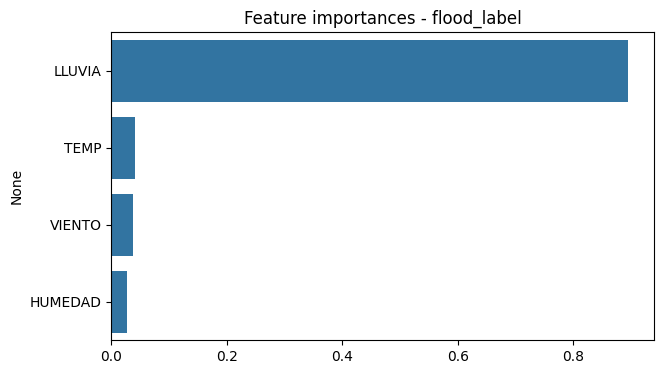

--- Target=drought_label - rows with features: 145
Train samples: 116 Test samples: 29
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         6

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

Confusion matrix:
[[23  0]
 [ 0  6]]
ROC AUC: 1.0
Train samples: 116 Test samples: 29
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         6

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

Confusion matrix:
[[23  0]
 [ 0  6]]
ROC AUC: 1.0


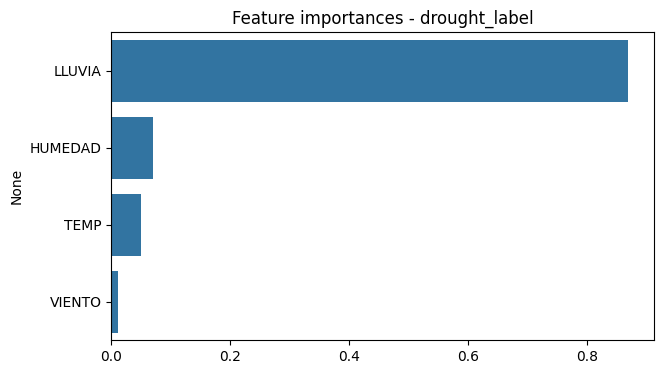

In [13]:
# Features elegidas
features = ['TEMP','HUMEDAD','LLUVIA','VIENTO']
# Usar la función robusta (train_and_evaluate_robust) definida arriba
results_flood = train_and_evaluate_robust(df, 'flood_label', features)
results_drought = train_and_evaluate_robust(df, 'drought_label', features)

# Si se entrenaron, mostrar resumen breve
if results_flood is None:
    print('No se entrenó modelo de inundación (pocas filas o datos faltantes)')
if results_drought is None:
    print('No se entrenó modelo de sequía (pocas filas o datos faltantes)')

## Entrenamiento de Modelos de Clasificación

En esta sección se entrenan dos modelos **Random Forest** independientes:

1. **Modelo de Inundación (`flood_label`)**: Detecta eventos de lluvia intensa (> 30 mm) que pueden causar inundaciones.
   - Predice la probabilidad de que se produzca un evento de inundación basado en características climáticas.
   
2. **Modelo de Sequía (`drought_label`)**: Detecta períodos sin lluvia (< 5 mm) que pueden indicar sequía.
   - Predice la probabilidad de un evento de sequía.

Cada modelo se entrena con 4 características climáticas:
- **TEMP**: Temperatura (°C)
- **HUMEDAD**: Humedad relativa (%)
- **LLUVIA**: Precipitación (mm)
- **VIENTO**: Velocidad del viento

### Interpretación de las métricas mostradas:
- **Precisión**: De los eventos predichos, ¿cuántos fueron correctos?
- **Recall**: De los eventos reales, ¿cuántos fueron detectados?
- **F1-Score**: Balance entre precisión y recall
- **Matriz de confusión**: Muestra verdaderos positivos (TP), falsos positivos (FP), verdaderos negativos (TN) y falsos negativos (FN)
- **ROC AUC**: Área bajo la curva ROC (1.0 es perfecto, 0.5 es aleatorio)

In [14]:
# Guardar modelos entrenados
out_dir = BASE_DIR / 'ml_models'
out_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(results_flood['model'], out_dir / 'rf_flood.joblib')
joblib.dump(results_drought['model'], out_dir / 'rf_drought.joblib')
print('Modelos guardados en', out_dir)

Modelos guardados en /Users/mrescobar/dev/Proyecto2--Python/ml_models


## Feature Importances (Importancia de Variables)

Las gráficas de **barras** muestran el peso relativo de cada variable en las predicciones del modelo:

- **LLUVIA** es típicamente la más importante (>80%) porque:
  - Define directamente la etiqueta objetivo (flood_label si lluvia > 30 mm, drought_label si lluvia < 5 mm)
  - Es el factor climático más crítico para predecir inundaciones y sequías

- **TEMP, HUMEDAD, VIENTO** contribuyen menos pero ayudan a capturar patrones contextuales:
  - Temperaturas altas + baja humedad pueden indicar condiciones secas
  - Altos vientos pueden acelerar la evaporación o la propagación de lluvia

**Nota importante**: En producción, es recomendable añadir features de **agregación temporal** (lluvia acumulada en 6/12/24 horas, cambios de presión, tendencias) para mejorar la capacidad predictiva temprana.

In [15]:
# Mapear probabilidad de inundación promedio por estación
# Prediccion por fila utilizando el modelo de flood (si tiene predict_proba)
df_map = df.copy()
model_f = results_flood['model']
feats = features
# Predecir probabilidades (para filas que tengan las features)
mask = df_map[feats].notna().all(axis=1)
if hasattr(model_f, 'predict_proba'):
    df_map.loc[mask, 'flood_proba'] = model_f.predict_proba(df_map.loc[mask, feats])[:,1]
else:
    df_map.loc[mask, 'flood_proba'] = model_f.predict(df_map.loc[mask, feats])

# Agregar por estación (media de probabilidad)
station_risk = df_map.dropna(subset=['lat','lon','flood_proba']).groupby(['station_id','station_name','lat','lon'])['flood_proba'].mean().reset_index()
station_risk.head()

,station_id,station_name,lat,lon,flood_proba
0,91029,CHANGUINOLA 2 (91-029),8.9303,-82.6900,0.00
1,91033,SE CHANGUINOLA (91-033),9.4069,-82.5639,0.00
2,93002,AEROPUERTO DE BOCAS (93-002),9.3403,-82.2450,0.98
3,93007,MIRAMAR (93-007),9.0017,-82.2592,0.00
4,95001,CANQUINTU (95-001),8.8536,-81.8164,0.00


## Riesgo de Inundación por Estación

Esta tabla agrega las **probabilidades de inundación** predichas por el modelo a nivel de estación meteorológica:

- **station_id**: Identificador único de la estación
- **station_name**: Nombre de la estación
- **lat, lon**: Coordenadas geográficas
- **flood_proba**: Probabilidad promedio de inundación (0.0 a 1.0)
  - **0.0 - 0.2** (Verde): Riesgo bajo de inundación
  - **0.2 - 0.5** (Naranja): Riesgo moderado de inundación
  - **0.5 - 1.0** (Rojo): Riesgo alto de inundación

Este resultado es **la base para generar alertas tempranas**: si una estación tiene `flood_proba > threshold` (p. ej., 0.7), se puede disparar una alerta a las comunidades cercanas.

In [17]:
# Mostrar mapa con marcadores coloreados por probabilidad
if 'station_risk' in globals() and not station_risk.empty:
    center = [station_risk['lat'].median(), station_risk['lon'].median()]
    m = folium.Map(location=center, zoom_start=7)
    for _, r in station_risk.iterrows():
        proba = float(r['flood_proba'])
        color = 'green' if proba < 0.2 else ('orange' if proba < 0.5 else 'red')
        popup = f"{r['station_name']} (id:{int(r['station_id'])}) - flood_prob={proba:.2f}"
        folium.CircleMarker(location=[r['lat'], r['lon']], radius=6,
                            color=color, fill=True, fill_opacity=0.7,
                            popup=popup).add_to(m)
    display(m)
else:
    print('No hay estaciones con lat/lon y probabilidad calculada')

## Mapa Interactivo de Riesgo de Inundación

El **mapa Folium** visualiza espacialmente las estaciones meteorológicas de Panamá coloreadas por riesgo de inundación:

- **Marcadores verdes** 🟢: Riesgo bajo (prob < 20%)
  - Estas zonas tienen condiciones climáticas que sugieren baja probabilidad de inundación

- **Marcadores naranjas** 🟠: Riesgo moderado (prob 20-50%)
  - Zonas con condiciones climáticas variables o mixtas

- **Marcadores rojos** 🔴: Riesgo alto (prob > 50%)
  - **Estas son las estaciones prioritarias para alertas tempranas**
  - Comunidades cercanas deben prepararse o evacuar

**Interactividad**: Puedes hacer zoom, desplazarte y hacer clic en los marcadores para ver el nombre de la estación y su probabilidad exacta de inundación.

**Aplicación práctica**: Integra este mapa en un dashboard público o sistema de alertas SMS para que los ciudadanos sepan qué zonas están en riesgo en tiempo real.